## Обучение опций 
Нашей задачей будет создание набора опций, каждая из которых должна быть обучена достигать определенные состояния в задаче такси. Для обучения мы будем использовать QLearningAgent, которого мы написали на одном из прошлых семинаров. 

In [1]:
# импортируем файлы и создаем окружение
import gym
import random
from collections import defaultdict

import numpy as np

environment = gym.make('Taxi-v2')
environment.render()


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [2]:
# создаем классс для Q-агента
class QLearningAgent:
    def __init__(self, alpha, epsilon, gamma, get_legal_actions):
        self.get_legal_actions = get_legal_actions
        self._q_values = defaultdict(lambda: defaultdict(lambda: 0))  # when called, non-existent values appear as zeros
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

    def get_q_value(self, state, action):
        """
          Returns Q(state,action)
        """
        return self._q_values[state][action]

    def set_q_value(self, state, action, value):
        """
          Sets the Qvalue for [state,action] to the given value
        """
        self._q_values[state][action] = value

    def get_value(self, state):
        """
          Returns max_action Q(state,action)
          where the max is over legal actions.
        """

        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        value = max([self.get_q_value(state, action) for action in possible_actions])
        return value

    def get_policy(self, state):
        """
          Compute the best action to take in a state.

        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        best_action = None

        for action in possible_actions:
            if best_action is None:
                best_action = action
            elif self.get_q_value(state, action) > self.get_q_value(state, best_action):
                best_action = action

        return best_action

    def get_action(self, state):
        """
          Compute the action to take in the current state, including exploration.

          With probability self.epsilon, we should take a random action.
          otherwise - the best policy action (self.getPolicy).

        """

        #
        possible_actions = self.get_legal_actions(state)

        # если в текущей ситуации нет возможных действий - возвращаем None
        if len(possible_actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            action = random.choice(possible_actions)
        else:
            action = self.get_policy(state)
        return action

    def update(self, state, action, next_state, reward):
        t = self.alpha * (reward + self.gamma * self.get_value(next_state) - self.get_q_value(state, action))
        reference_qvalue = self.get_q_value(state, action) + t
        self.set_q_value(state, action, reference_qvalue)


### Задание 1 
Разберемся как реализована среда Taxi: https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py

Создадим 4 окружения аналогичных Taxi, в которых целью агента будет достижение одной из точек: R, G, B, Y соответственно. 

In [3]:
class TaxiStepWrapper(gym.Wrapper):
    def __init__(self, env, target_id, target_reward):
        super().__init__(env)
        self._target = target_id
        self._target_reward = target_reward

    def _step(self, action):
        # \begin{solution}
        state, reward, _, obs = self.unwrapped.step(action)
        if self.unwrapped.locs[self._target][:2] == tuple(self.unwrapped.decode(state))[:2]:
            reward = self._target_reward
            is_done = True
        else:
            is_done = False
        # \end{solution}

        return state, reward, is_done, obs


Проверим нашу обертку (wrapper), используя случайную стратегию.  Порядок точек должен быть  R, G, Y, B.

In [4]:
for target in range(4):
    # \begin{solution}
    wrapped_env = TaxiStepWrapper(env=environment, target_id=target, target_reward=50)
    done = False
    wrapped_env.reset(), 0
    while not done:
        s, r, done, _ = wrapped_env.step(random.randint(0, 5))
    # проверим точки и вознаграждения, которые мы задали (порядок должен быть R, G, Y, B):
    # \end{solution}

    wrapped_env.render()
    print("state:{s} reward:{r}\n".format(**locals()))


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
state:4 reward:50

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
state:92 reward:50

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
state:414 reward:50

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
state:471 reward:50



In [5]:
# воспользуемся методом play_and_train, который мы реализовали на прошлом семинаре
def play_and_train(env, agent, t_max=10 ** 4):
    total_discounted_reward = 0.0
    s = env.reset()
    for t in range(t_max):
        a = agent.get_action(s)
        next_s, r, done, _ = env.step(a)
        agent.update(s, a, next_s, r)
        s = next_s
        total_discounted_reward += r
        if done:
            break
    return total_discounted_reward


### Задание 2 
1. Обучим агентов на созданных нами окружениях.
2. Создадим упрощенный вариант опций, каждая опция будет иметь стратегию, множество начальных состояний и множество конечных состояний.

In [6]:
n_actions = environment.action_space.n

# параметры, которые будут использовать агенты
params = {"alpha": 0.1, "epsilon": 0.1, "gamma": 0.99, "get_legal_actions": lambda s: range(4)}

# создаем агентов 
agents_for_options = [QLearningAgent(**params) for _ in range(4)]

for index in range(4):
    # \begin{solution}
    wrapped_env = TaxiStepWrapper(env=environment, target_id=index, target_reward=50)
    for _ in range(2500):
        play_and_train(env=wrapped_env, agent=agents_for_options[index])
    # \end{solution}

In [7]:
# реализуем класс опции
class Option:
    def __init__(self, policy, termination_prob, initial):
        self.policy = policy
        self.termination_prob = termination_prob
        self.initial_states = initial

    def can_start(self, state):
        return state in self.initial_states

    def terminate(self, state):
        return random.random() <= self.termination_prob[state]

    def get_action(self, state):
        return self.policy.get_action(state)


In [8]:
options = []
for index, agent in enumerate(agents_for_options):
    # \begin{solution}
    initial_states, termination_states = set(), set()
    for state in range(environment.observation_space.n):
        if environment.unwrapped.locs[index][:2] == tuple(environment.unwrapped.decode(state))[:2]:
            initial_states.add(state)
        else:
            termination_states.add(state)

    termination_prob = {}
    for state in range(environment.observation_space.n):
        termination_prob[state] = float(not state in termination_states)
    initial = set(termination_states)
    # \end{solution}

    options.append(Option(policy=agent, termination_prob=termination_prob, initial=initial))


### Задание 3
Напишем функцию, которая будет запускать опцию и возвращать дисконтированное вознаграждение, опираясь на число совершенных действий
$$ R = r_{1} + \gamma r_{2} + \gamma^{2} r_{3} + \dots + \gamma^{t-1}r_{t}$$

In [9]:
def apply_option(option, gamma, env, debug=False):
    reward = 0
    steps = 0

    # \begin{solution}
    if not option.can_start(state):
        return None
    # \end{solution}

    # \begin{solution}
    
    # получаем состояние среды
    s, d, obs = env.unwrapped.s, False, None
    while True:
        act = option.get_action(s)

        s, r, d, obs = env.step(act)
        reward += r * (gamma ** steps)
        steps += 1
        if debug:
            env.render()
        if option.terminate(s):
            if debug:
                print("Option terminated")
            break
        if d:
            if debug:
                print('Environment is done')
            break
    
    if debug:
        print("SMDP reward: {reward}".format(**locals()))
    # \end{solution}
    # state, reward, is_done, obs
    return s, reward, d, obs


In [10]:
# проверим работу метода
env = gym.make('Taxi-v2')
s = env.reset()

r = apply_option(options[0], 0.99, env, debug=True)


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Option terminated
SMDP reward: -1.0


Кажется, что все хорошо, но мы забыли рассмотреть вариант, когда пассажир может находиться в такси! Переведем среду в состояние, где пассажира мы уже подобрали и посмотрим, как ведет себя  одна из опций.

In [11]:
s = env.reset()
env.unwrapped.s = 499
env.render()
print("\n" * 2)
r = apply_option(options[0], 0.99, env, debug=True)


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+




+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : 

### Задание 4
Видим, что опции не обучились действовать в такой ситуации. 
Исправим нашу функцию обучения так, чтобы опции работали корректно для всех возможных состояний среды и сгенерируем их заново.

In [12]:
def play_and_train_modified(env, agent, t_max=10 ** 4):
    # Зададим новую функцию play_and_train, которая в качестве начального состояния выбирает любое состояние среды,
    # включая и то, когда пассажир уже находится в такси

    total_discounted_reward = 0.0
    s = env.reset()

    # \begin{solution}
    env.unwrapped.s = random.randint(0, 499)
    # \end{solution}

    for t in range(t_max):
        a = agent.get_action(s)
        next_s, r, done, _ = env.step(a)
        agent.update(s, a, next_s, r)
        s = next_s
        total_discounted_reward += r
        if done:
            break
    return total_discounted_reward


for index in range(4):
    for _ in range(5250):
        wrapped_env = TaxiStepWrapper(env=environment, target_id=index, target_reward=50)
        play_and_train_modified(env=wrapped_env, agent=agents_for_options[index])


Запустим данную ячейку несколько раз и убедимся, что агент обучился для всех случаев!

In [13]:
env = environment
s = env.reset()

env.unwrapped.s = random.randint(0, 499)
apply_option(options[0], 0.99, env, debug=True)


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Option terminated
SMDP reward: -1.0


(7, -1.0, False, {'prob': 1.0})

### Бонус 
Реализуйте иерархию, используя элементарные (опции из одного действия) и обученные опции.

#### Добавим элементарные опции (опции из одного действия: посадка и высадка пассажира):

In [14]:
# для действий 4-5 (pickup, dropoff) создаем элементарные опции:
class OneActionAgent:
    def __init__(self, action):
        self.action = action
    
    def get_action(self, state):
        return self.action
    
    def update(*args, **kwargs):
        pass

options = options[:4]    
for action in range(4, 6):
    # элементарная опция начинается в любом состоянии, выполняет любое действие и завершается
    initial = set(range(environment.observation_space.n))
    termination_prob = {_:1.0 for _ in  range(environment.observation_space.n)}   
    options.append(Option(policy=OneActionAgent(action), termination_prob=termination_prob, initial=initial))

#### Проверим элементарные опции:

In [15]:
env = environment
s = env.reset()

env.unwrapped.s = random.randint(0, 499)
apply_option(options[0], 0.99, env, debug=True)
apply_option(options[4], 0.99, env, debug=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Option terminated
SMDP reward: -1.99
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
Option terminated
SMDP reward: -10.0


(12, -10.0, False, {'prob': 1.0})

#### Реализуем обертку для окружения, которая вместо действий применяет опции (в качестве входа - список опций):

In [16]:
class OptionTaxiStepWrapper(gym.Wrapper):
    def __init__(self, env, options, gamma=0.99):
        self.options = options
        self.gamma = gamma
        super().__init__(env)

    def _step(self, action):
        state, reward, is_done, obs = apply_option(self.options[action], self.gamma, self.unwrapped)
        return state, reward, is_done, obs


#### Создаем агента, который учится, используя окружение с опциями:

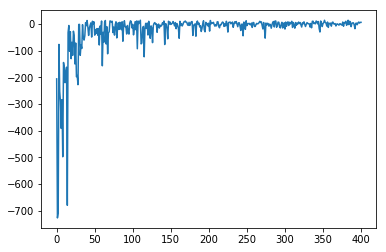

In [17]:
option_agent = QLearningAgent(alpha=0.1, epsilon=0.1, gamma=0.99, get_legal_actions=lambda s: range(len(options)))

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
# создаем окружение, использующее опции
env = OptionTaxiStepWrapper(gym.make('Taxi-v2'), options=options)
rewards_options = []
for episode in range(500):
    rewards_options.append(play_and_train(env=env, agent=option_agent))
    
    if episode % 100 == 0:
        clear_output(True)
        option_agent.epsilon *= 0.99
        plt.plot(rewards_options)
        plt.show()